# Sentiment mining: corona tweets
- Pauline Claes. 
- Machine Learning 1 project 
- Friday 22 January 2021

## The data set
The data set was downloaded from the data science community Kaggle (Kaggle, 2020). The original file contained two CSV-files; one for testing and one for training. The original test file contained 3,798 instances and the train file 41,158 instances. Because the size of the original test file represented less than 10% of the train file, and it was clear that we would not use the entire data set for computational efficiency, we decided to only use the train file and do all of our preprocessing steps on that data set. Moving forward, we start with one data set (CSV-file) containing 41,158 data points. 
This data set has five input features and one output feature (the class labels). The input features are: “UserName”, “ScreenName”, “Location”, “TweetAt” and “OriginalTweet”. “UserName” is an integer that functions as an index. “ScreenName” is a number that represents the unique and anonymized IDs of the tweets. “TweetAt” is the date when the tweet was posted and “OriginalTweet” is the actual tweet. For this project, we will only be using the latter as the input feature, as we are only interested in the textual content. The last column, the output feature “Sentiment” is the label that we want to predict. This column contains five class labels: “Extremely Negative”, “Negative”, “Neutral”, “Positive” and “Extremely Positive”. According to Kaggle, this data set has been manually annotated. Unfortunately, it did not come with a description of the criteria used to assign a class to a certain tweet. Therefore, after having examined the data in more detail, it was unclear whether there was a well-delineated distinction between “Extremely Negative” and “Negative”, and between “Extremely Positive” and “Positive”. This is why we have merged these classes into respectively “Negative” and “Positive” in the preprocessing of the data set, leaving us with three class labels in which the tweets can be classified: “Negative”, “Neutral” and “Positive”. 

## Preprocessing

As described above, the used data set contains 41,158 instances. We load the data set as a pandas.DataFrame and inspect it to see whether there are any missing values. There are in fact 8,666 missing values in the “Location” column, and we subsequently drop the rows containing missing values. Even though this might not be necessary because that column will not be used as an input feature, it is useful to do so for the educational purposes of this paper. In addition to that, we merge the class labels “Extremely Negative” and “Negative”, and “Extremely Positive” and “Positive” in the “Sentiment” column as described above. After that, we take a random sample of 50% of the data set for the purpose of computational efficiency during the training and testing processes. In order to assure replicability, we instantiate a random_state. We are now left with a data set containing 16,246 data points. Furthermore, we verify whether the labels are balanced; meaning that they have the same number of instances per class label in the “Sentiment” column. As this is not the case, we we set all the value counts for the three classes equal to the class with the least amount of instances (“Neutral”, with 3,093 instances), to avoid bias in our training set. By doing that, we obtain 3,093 instances in each class. 
After all of these preprocessing steps, we are left with a total of 9,279 instances equally spread across the three classes “Negative”, “Neutral” and “Positive”. This is the subset on which we will perform our model selection.
In order to adequately assess a model’s ability to generalize to unseen data, it is important to split the data into a train and test set. However, there is a notion of ‘information leakage’ that is playing a noticeable role here. To be more precise; when running models multiple times, the test set can become part of the training set, as it is not the first time that the model sees it. Therefore, it is useful to split the data into a training, validation and test set. All of the pipelines will be fit on the training part an the performance of all of the individual pipelines will be assessed on the validation part. When we have found the best performing pipeline after model selection, we will retrain that pipeline on the training data and assess its performance on the test set that has been kept apart until then. This way, our model will not get too optimistic after several rounds of fitting. Using the SciKit-learn module train_test_split, we define a test part containing 20% of our data set and a training part containing 80% of our data set. Subsequently, we define a validation split containing 25% of our training part. Furthermore, we instantiate a random_state for replicability purposes, shuffle the data so that it is no longer in any particular order (for example ordered by class label) and we stratify the data so that each of the train, validation and test parts contain the same amount of instances per class.
Consequently, the train input (X_train) is a vector containing 5,567 training input instances (the tweets), the validation input (X_val) and test input (X_test) are vectors each containing 1,856 instances (the tweets). The train output (y_train) is a vector containing 5,567 training output instances (the class labels), the validation output (y_val) and test output (y_test) are vectors each containing 1,856 instances (the class labels). 

In [124]:
# import packages
import pandas as pd
import numpy as np

In [125]:
# import modules
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import naive_bayes
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from nltk.tokenize import word_tokenize 
import matplotlib.pyplot as plt
nltk__word_tokenizer = word_tokenize

In [134]:
# read in the data
df = pd.read_csv("corona-tweets.csv", sep=",")

In [135]:
# inspect
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [136]:
# inspect
df.tail()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
41153,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41154,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41155,44953,89905,NaN,14-04-2020,You know its getting tough when @KameronWilds...,Positive
41156,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral
41157,44955,89907,i love you so much || he/him,14-04-2020,@TartiiCat Well new/used Rift S are going for ...,Negative


In [137]:
# inspect
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41158 entries, 0 to 41157
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41158 non-null  int64 
 1   ScreenName     41158 non-null  int64 
 2   Location       32492 non-null  object
 3   TweetAt        41158 non-null  object
 4   OriginalTweet  41158 non-null  object
 5   Sentiment      41158 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [138]:
# check to see if there are any missing values
df.isnull().sum()

UserName            0
ScreenName          0
Location         8666
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [139]:
# drop rows containing missing values
df = df.dropna()
# check to see if it worked
df.isnull().sum()

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64

In [140]:
# check to see what we have left
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32492 entries, 0 to 41157
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       32492 non-null  int64 
 1   ScreenName     32492 non-null  int64 
 2   Location       32492 non-null  object
 3   TweetAt        32492 non-null  object
 4   OriginalTweet  32492 non-null  object
 5   Sentiment      32492 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.7+ MB


In [141]:
# check to see if the labels are stratified
df.Sentiment.value_counts()

Positive              9024
Negative              7800
Neutral               6134
Extremely Positive    5301
Extremely Negative    4233
Name: Sentiment, dtype: int64

In [142]:
# merge Extremely Positive and Positive
df['Sentiment'] = df.Sentiment.str.replace('Extremely Positive', 'Positive')
# merge Extremely Negative and Negative
df['Sentiment'] = df.Sentiment.str.replace('Extremely Negative', 'Negative')

In [143]:
# check to see if it worked
df.Sentiment.value_counts()

Positive    14325
Negative    12033
Neutral      6134
Name: Sentiment, dtype: int64

In [144]:
# take half of the data for computational efficiency by stating frac=0.5
# create replicability by random_state=42
tweets = df.sample(frac=0.5, random_state=42)

In [145]:
# check if they are still correctly stratified
tweets.Sentiment.value_counts()

Positive    7140
Negative    6013
Neutral     3093
Name: Sentiment, dtype: int64

In [146]:
# set the value_counts equal to each other again
min_number = np.min(tweets.Sentiment.value_counts())
tweets = tweets.groupby('Sentiment', group_keys=False).apply(lambda x: x.sample(min_number))

In [147]:
# check to see if it worked
tweets.Sentiment.value_counts()

Positive    3093
Negative    3093
Neutral     3093
Name: Sentiment, dtype: int64

In [148]:
# divide subset of data into train and test part
from sklearn.model_selection import train_test_split

X = tweets["OriginalTweet"].values # input feature
y = tweets["Sentiment"].values # label

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, # 20% test data
                                                    random_state = 42, # replicable results
                                                    shuffle = True, # shuffle
                                                    stratify = y) # stratify

In [150]:
# split up train part into a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                 test_size = 0.25,
                                                 random_state = 42,
                                                 shuffle = True, 
                                                 stratify = y_train)

In [151]:
# check the shapes of the train and test data)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_val.shape, y_test.shape

((5567,), (1856,), (1856,), (5567,), (1856,), (1856,))

We now have: 
- X_train: originally 80% of input instances from our total dataset. This is what we will use to train the model on the input.
    - X_val: 25% of our input training part. This is what we will use to test our model's ability to generalize to unseen datapoints.
- y_train: originally 80% of output labels from our total dataset. This is what we will use to train the model on the desired output.
    - y_val: 25% of our output training part. This is what we will use to compare the predictions of the model to the desired output.
- X_test: 20% of the input instances from our total dataset. This is the part of the data that we will keep apart until the very end, to test our final (best-performing) model on its performance to generalize to unseen data.
- y_test: 20% of the output instances from our total dataset. We will keep this part of the data separated until the very end, to compare the model's predictions on X_test to the actual desired output.

After we have trained each of the models, we will test its performance with a test set. If we would only have a train and a test set, the test set will eventually become part of the training set if we try it out multiple times and the scores might not be reliable (too optimistic) anymore. Therefore, it is useful to create a validation set. We take 25% of the training set to create a validation set. This is the set that will be used to test each of the models' performance right after training. Only at the end, we will use our test set to assess our best performing model's ability to generalize to unseen data.

# Pipeline 1. CountVectorizer and SGDClassifier
This pipeline includes CountVectorizer with max_features set to 10,000 and the NLTK word tokenizer, as well as the Stochastic Gradient Descent classifier with its default parameters, a log loss function and a random_state. The other default parameters include alpha set to 0.0001, max_iter set to 1000 and l2 penalty. Judging by the classification report, this pipeline performed relatively poorly, obtaining a macro average f1-score of 0.62.  The boxplot of the cross_val_score shows us that the mean macro average f1-score for the cross-validation is around 0.62. Both the classification report and the confusion matrix seem to point toward a slightly better performance on the “Neutral” class.

In [170]:
# default parameters of CountVectorizer that we might want to optimize
CountVectorizer().get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [171]:
# default parameters of SGDClassifier that we might want to optimize.
SGDClassifier().get_params()

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [172]:
# instantiate a CountVectorizer
cvect = CountVectorizer(max_features=10000, # 10,000 most frequent words
                        tokenizer = nltk__word_tokenizer) # word tokenizer imported from NLTK
                          

# instantiate an SGDClassifier with default parameters and log loss function
sgdclf = SGDClassifier(loss = 'log', random_state=42)

# Instantiate the pipeline
pipeline1 = make_pipeline(cvect, sgdclf)

In [192]:
#pipeline1.get_params()

In [174]:
# fit the training data to the pipeline
pipeline1.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=10000,
                                 tokenizer=<function word_tokenize at 0x7fb13d672dc0>)),
                ('sgdclassifier', SGDClassifier(loss='log', random_state=42))])

In [175]:
# fit the test input to the pipeline to predict the classes on unseen data
y_pred1 = pipeline1.predict(X_val)

In [176]:
print(classification_report(y_val, y_pred1))

              precision    recall  f1-score   support

    Negative       0.62      0.65      0.63       619
     Neutral       0.60      0.56      0.58       619
    Positive       0.64      0.64      0.64       618

    accuracy                           0.62      1856
   macro avg       0.62      0.62      0.62      1856
weighted avg       0.62      0.62      0.62      1856



In [35]:
%time scores = cross_val_score(estimator=pipeline1, X=X_train, y=y_train, cv=10, scoring='f1_macro', n_jobs=-1)


CPU times: user 48.6 ms, sys: 6.53 ms, total: 55.2 ms
Wall time: 3.01 s


<AxesSubplot:>

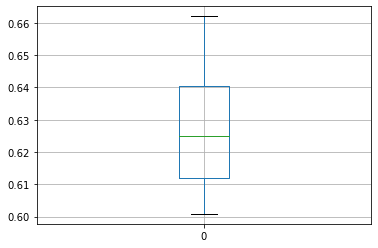

In [177]:
pd.DataFrame(scores).boxplot()

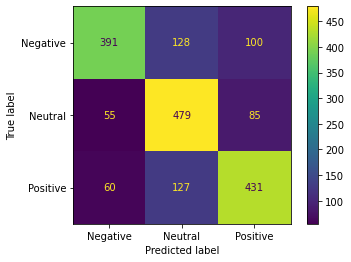

In [37]:
fig, ax = plt.subplots()
plot_confusion_matrix(pipeline1, 
                      X_val,
                      y_val,
                      labels=pipeline1.classes_, 
                      ax = ax)
plt.show()

# Pipeline 2. CountVectorizer and Support Vector Machines
This pipeline includes the CountVectorizer with max_features set to 10,000 and the NLTK word tokenizer, as well as the Support Vector Machines classifier with its default parameters. These include C set to 1.0, gamma set to ‘scale’, an RBF-kernel (Radial Basis Function) and max_iter set to -1 (no limit). The classification report indicates that this pipeline’s performance is relatively unsatisfying, reaching a macro average f1-score of 0.62. Furthermore, the cross_val_score boxplot estimates the mean macro average f1-score for the cross-validation slightly beneath 0.60. Both the classification report and the confusion matrix show a slightly better performance on the “Neutral” class.

In [99]:
SVC().get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [39]:
cvect = CountVectorizer(max_features = 10000, 
                          tokenizer = nltk__word_tokenizer)

svm = SVC(random_state=42)

pipeline2 = make_pipeline(cvect, svm)

In [40]:
pipeline2.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=10000,
                                 tokenizer=<function word_tokenize at 0x7fb13d672dc0>)),
                ('svc', SVC(random_state=42))])

In [41]:
y_pred2 = pipeline2.predict(X_val)

In [42]:
print(classification_report(y_val, y_pred2))

              precision    recall  f1-score   support

    Negative       0.63      0.57      0.60       619
     Neutral       0.61      0.70      0.65       619
    Positive       0.63      0.59      0.61       618

    accuracy                           0.62      1856
   macro avg       0.62      0.62      0.62      1856
weighted avg       0.62      0.62      0.62      1856



In [45]:
%time scores2 = cross_val_score(estimator=pipeline2, X=X_train, y=y_train, cv=10, scoring='f1_macro', n_jobs=-1)

CPU times: user 59.1 ms, sys: 23.1 ms, total: 82.2 ms
Wall time: 13.6 s


<AxesSubplot:>

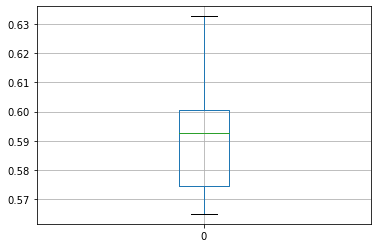

In [46]:
pd.DataFrame(scores2).boxplot()

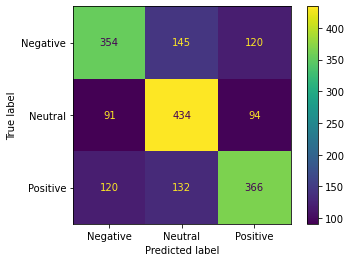

In [47]:
fig, ax = plt.subplots()
plot_confusion_matrix(pipeline2, 
                      X_val,
                      y_val,
                      labels=pipeline2.classes_, 
                      ax = ax)
plt.show()

# Model 3. Pipeline for CountVectorizer and Naive Bayes Classifier
This pipeline combines the CountVectorizer with max_features set to 10,000 and the NLTK word tokenizer and a multinomial Naïve Bayes classifier with its default parameters, which has alpha set to 1.0. This pipeline reaches a macro average f1-score of 0.63 in the classification report, which indicates that it performs slightly better than the second pipeline, without outperforming the first one. The cross_val_score boxplot indicates that the mean macro average f1-score for the cross-validation is slightly above 0.60. The classification report as well as the confusion matrix show a slightly better performance on the “Negative” class.

In [50]:
cvect = CountVectorizer(max_features = 10000, 
                          tokenizer = nltk__word_tokenizer)

nbc = naive_bayes.MultinomialNB()

pipeline3 = make_pipeline(cvect, nbc)

In [100]:
naive_bayes.MultinomialNB().get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}

In [51]:
pipeline3.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=10000,
                                 tokenizer=<function word_tokenize at 0x7fb13d672dc0>)),
                ('multinomialnb', MultinomialNB())])

In [53]:
y_pred3 = pipeline3.predict(X_val)

In [54]:
print(classification_report(y_val, y_pred3))

              precision    recall  f1-score   support

    Negative       0.64      0.68      0.66       619
     Neutral       0.66      0.57      0.61       619
    Positive       0.59      0.64      0.61       618

    accuracy                           0.63      1856
   macro avg       0.63      0.63      0.63      1856
weighted avg       0.63      0.63      0.63      1856



In [56]:
%time scores3 = cross_val_score(estimator=pipeline3, X=X_train, y=y_train, cv=10, scoring='f1_macro', n_jobs=-1)


CPU times: user 45.6 ms, sys: 8.44 ms, total: 54.1 ms
Wall time: 2.53 s


<AxesSubplot:>

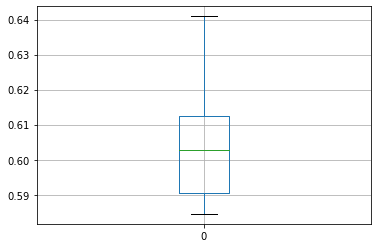

In [57]:
pd.DataFrame(scores3).boxplot()

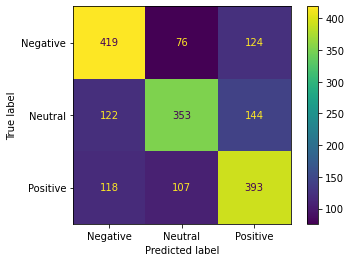

In [58]:
fig, ax = plt.subplots()
plot_confusion_matrix(pipeline3, 
                      X_val,
                      y_val,
                      labels=pipeline3.classes_, 
                      ax = ax)
plt.show()

# Pipeline 4. TF-IDF Vectorizer and SGDClassifier
This pipeline includes the Tf-Idf Vectorizer with max_features set to 10,000 and the NLTK word tokenizer, as well as the Stochastic Gradient Descent classifier with its default parameters, log loss function and a random_state. The default parameters of the SGDClassifier include alpha set to 0.0001, max_iter set to 1000 and l2 penalty. The classification report points toward a macro average f1 score of 0.68, while the cross_val_score boxplot estimates a mean macro average f1-score for the cross-validation. It seems that there is a more equal distribution across the predictions for each of the classes in this pipeline.

In [106]:
TfidfVectorizer().get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [107]:
SGDClassifier().get_params()

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [178]:
tvect = TfidfVectorizer(max_features=10000, 
                          tokenizer = nltk__word_tokenizer)

# sgdclassifier with default parameters and log loss function
sgdclf = SGDClassifier(loss = 'log', random_state = 42) 

pipeline4 = make_pipeline(tvect, sgdclf)

In [179]:
pipeline4.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=10000,
                                 tokenizer=<function word_tokenize at 0x7fb13d672dc0>)),
                ('sgdclassifier', SGDClassifier(loss='log', random_state=42))])

In [180]:
y_pred4 = pipeline4.predict(X_val)

In [181]:
print(classification_report(y_val, y_pred4))

              precision    recall  f1-score   support

    Negative       0.70      0.62      0.66       619
     Neutral       0.65      0.75      0.69       619
    Positive       0.69      0.66      0.67       618

    accuracy                           0.68      1856
   macro avg       0.68      0.68      0.68      1856
weighted avg       0.68      0.68      0.68      1856



In [182]:
%time scores4 = cross_val_score(estimator=pipeline4, X=X_train, y=y_train, cv=10, scoring='f1_macro', n_jobs=-1)


CPU times: user 87.1 ms, sys: 93.4 ms, total: 180 ms
Wall time: 4.24 s


<AxesSubplot:>

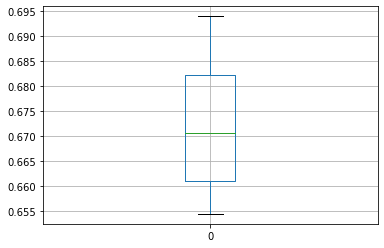

In [183]:
pd.DataFrame(scores4).boxplot()

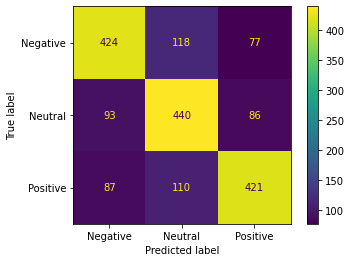

In [72]:
fig, ax = plt.subplots()
plot_confusion_matrix(pipeline4, 
                      X_val,
                      y_val,
                      labels=pipeline4.classes_, 
                      ax = ax)
plt.show()

# Pipeline 5. TF-IDF Vectorizer and Support Vector Machine
In this pipeline, we combine the Tf-Idf Vectorizer with max_features set to 10,000 and the NLTK word tokenizer, as well as the Support Vector Machines classifier with its default parameters, which include C set to 1.0, gamma set to ‘scale’, an RBF-kernel (Radial Basis Function) and max_iter set to -1 (no limit). Reaching a macro average f1-score of 0.66, this model is rather mediocre. The boxplot for the cross-validation confirms this by indicating a mean macro average f1-score of around 0.64. The confusion matrix indicates that the model performs slightly better on the “Neutral” class.

In [73]:
TfidfVectorizer().get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [74]:
tfidf = TfidfVectorizer(max_features = 10000, 
                        tokenizer = nltk__word_tokenizer)

svm = SVC(random_state=42) # with default parameters: rbf, C=1.0, gamma='scale'

pipeline5 = make_pipeline(tfidf, svm)

In [75]:
pipeline5.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=10000,
                                 tokenizer=<function word_tokenize at 0x7fb13d672dc0>)),
                ('svc', SVC(random_state=42))])

In [76]:
y_pred5 = pipeline5.predict(X_val)

In [77]:
print(classification_report(y_val, y_pred5))

              precision    recall  f1-score   support

    Negative       0.66      0.65      0.66       619
     Neutral       0.66      0.68      0.67       619
    Positive       0.68      0.66      0.67       618

    accuracy                           0.66      1856
   macro avg       0.67      0.66      0.66      1856
weighted avg       0.67      0.66      0.66      1856



In [79]:
%time scores5 = cross_val_score(estimator=pipeline5, X=X_train, y=y_train, cv=10, scoring='f1_macro', n_jobs=-1)

CPU times: user 45.2 ms, sys: 5.17 ms, total: 50.3 ms
Wall time: 15.8 s


<AxesSubplot:>

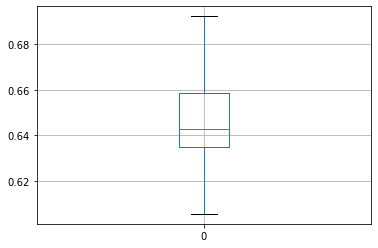

In [80]:
pd.DataFrame(scores5).boxplot()

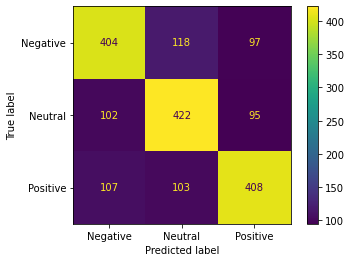

In [81]:
fig, ax = plt.subplots()
plot_confusion_matrix(pipeline5, 
                      X_val,
                      y_val,
                      labels=pipeline5.classes_, 
                      ax = ax)
plt.show()

# Pipeline 6. TF-IDF Vectorizer and multinomial Naive Bayes Classifier
In this pipeline, we include the Tf-Idf Vectorizer with max_features set to 10,000 and the NLTK word tokenizer, together with a multinomial Naïve Bayes classifier with its default parameters. This classifier does not support the use of random_state (replicability), so it is not instantiated. Judging by the classification report, this pipeline also covers mediocre ground, reaching a macro average f1-score of 0.63. Even though this does not outperform the pipeline with CountVectorizer and multinomial Naïve Bayes classifier, the cross-validation boxplot for this pipeline indicates a mean macro average f1-score of around 0.63 (compared to 0.60 for the pipeline with CountVectorizer and NBC). The confusion matrix indicates that this pipeline slightly underperforms on the “Neutral” class.

In [82]:
naive_bayes.MultinomialNB().get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}

In [83]:
tvect = TfidfVectorizer(max_features=10000, 
                          tokenizer = nltk__word_tokenizer)

nbc = naive_bayes.MultinomialNB()

pipeline6 = make_pipeline(tvect, nbc)

In [84]:
pipeline6.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=10000,
                                 tokenizer=<function word_tokenize at 0x7fb13d672dc0>)),
                ('multinomialnb', MultinomialNB())])

In [85]:
y_pred6 = pipeline6.predict(X_val)

In [86]:
print(classification_report(y_val, y_pred6))

              precision    recall  f1-score   support

    Negative       0.64      0.70      0.67       619
     Neutral       0.71      0.50      0.59       619
    Positive       0.59      0.71      0.64       618

    accuracy                           0.64      1856
   macro avg       0.65      0.64      0.63      1856
weighted avg       0.65      0.64      0.63      1856



In [92]:
%time scores6 = cross_val_score(estimator=pipeline6, X=X_train, y=y_train, cv=10, scoring='f1_macro', n_jobs=-1)

CPU times: user 45.8 ms, sys: 6.39 ms, total: 52.2 ms
Wall time: 2.99 s


<AxesSubplot:>

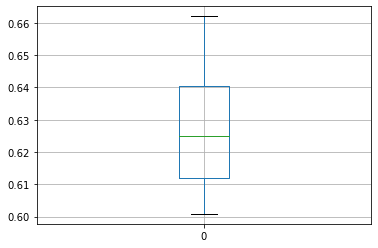

In [93]:
pd.DataFrame(scores6).boxplot()

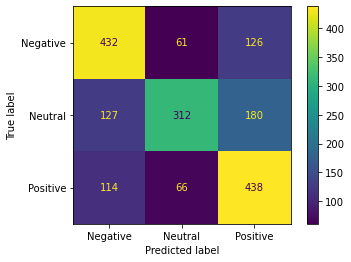

In [94]:
fig, ax = plt.subplots()
plot_confusion_matrix(pipeline6, 
                      X_val,
                      y_val,
                      labels=pipeline6.classes_, 
                      ax = ax)
plt.show()

# Pipeline 7. Final assessment of pipeline 4 on the test set

In this part, we retrain pipeline 4 on the training data set and assess its performance onto the test set that has been kept apart until now. Pipeline 4 was the best performing model, reaching a macro average f1-score of 0.68, containing the Tf-Idf Vectorizer and the Stochastic Gradient Descent classifier. The pipeline seems to perform slightly worse on the unseen test set, reaching a macro average f1-score of 0.67, which is also confirmed by the mean cross-validation macro average f1-score in the boxplot. As was the case with pipeline 4, this pipeline also slightly performs better on the “Neutral” class.

In [185]:
pipeline4.get_params()

{'memory': None,
 'steps': [('tfidfvectorizer',
   TfidfVectorizer(max_features=10000,
                   tokenizer=<function word_tokenize at 0x7fb13d672dc0>)),
  ('sgdclassifier', SGDClassifier(loss='log', random_state=42))],
 'verbose': False,
 'tfidfvectorizer': TfidfVectorizer(max_features=10000,
                 tokenizer=<function word_tokenize at 0x7fb13d672dc0>),
 'sgdclassifier': SGDClassifier(loss='log', random_state=42),
 'tfidfvectorizer__analyzer': 'word',
 'tfidfvectorizer__binary': False,
 'tfidfvectorizer__decode_error': 'strict',
 'tfidfvectorizer__dtype': numpy.float64,
 'tfidfvectorizer__encoding': 'utf-8',
 'tfidfvectorizer__input': 'content',
 'tfidfvectorizer__lowercase': True,
 'tfidfvectorizer__max_df': 1.0,
 'tfidfvectorizer__max_features': 10000,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__norm': 'l2',
 'tfidfvectorizer__preprocessor': None,
 'tfidfvectorizer__smooth_idf': True,
 'tfidfvectorizer__stop_words': No

In [186]:
pipeline4.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=10000,
                                 tokenizer=<function word_tokenize at 0x7fb13d672dc0>)),
                ('sgdclassifier', SGDClassifier(loss='log', random_state=42))])

In [187]:
y_pred7 = pipeline4.predict(X_test)

In [188]:
print(classification_report(y_test, y_pred7))

              precision    recall  f1-score   support

    Negative       0.70      0.64      0.67       618
     Neutral       0.63      0.72      0.67       619
    Positive       0.69      0.65      0.67       619

    accuracy                           0.67      1856
   macro avg       0.67      0.67      0.67      1856
weighted avg       0.67      0.67      0.67      1856



In [189]:
%time scores7 = cross_val_score(estimator=pipeline4, X=X_train, y=y_train, cv=10, scoring='f1_macro', n_jobs=-1)

CPU times: user 44.4 ms, sys: 5.8 ms, total: 50.2 ms
Wall time: 3.08 s


<AxesSubplot:>

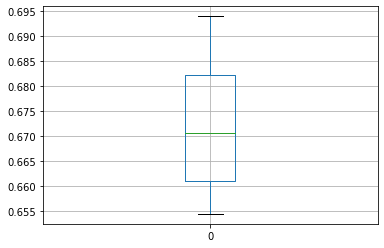

In [190]:
pd.DataFrame(scores7).boxplot()

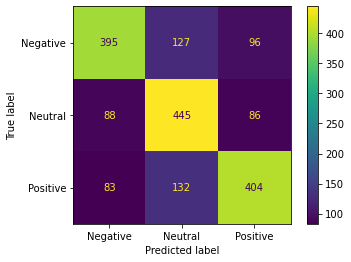

In [191]:
fig, ax = plt.subplots()
plot_confusion_matrix(pipeline4, 
                      X_test,
                      y_test,
                      labels=pipeline4.classes_, 
                      ax = ax)
plt.show()

# Conclusion
In this paper, we investigated six pipelines that combined each of the selected vectorizers (CountVectorizer and Tf-Idf Vectorizer) with each of the selected classifiers (Stochastic Gradient Descent Classifier, Support Vector Machine and multinomial Naïve Bayes classifier). Even though all of the performances are comparable and within a similar range of 0.60 to 0.68 in macro average f1-score, pipeline 4 was the best performing one. This pipeline consisted of the Tf-Idf Vectorizer (with max_features set to 10,000 and the NLTK word tokenizer) and the Stochastic Gradient Descent classifier (with log loss function and its other default parameters). When we fit this pipeline on the training set and used it to predict on the unseen test set, it reached a macro average f1-score of 0.67. The poorest performance came from pipeline 3, containing the CountVectorizer (with max_features set to 10,000 and the NLTK word tokenizer) and the multinomial Naïve Bayes classifier with its default parameters, reaching a macro average f1-score of 0.60. 
As stated above, there were some important limitations to this project. First of all, we merged the original five class labels into three class labels: “Positive”, “Neutral” and “Negative”. Secondly, we only used half of the data set for computational efficiency. 
In conclusion, pipeline 4 was the best performing pipeline, reaching a macro average f1-score of 0.68 during model selection and 0.67 during the assessment on the test set. Pipeline 3 had the lowest performance, reaching a macro average f1-score of 0.60. 
For this project, we only used the textual content in the “OriginalTweet” column to predict class labels. For future research, it might be interesting to include “Location” or “TweetAt” to see how these could potentially influence the “Sentiment” classification. 
